In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, sosfilt, sosfreqz, bilinear
import math

In [2]:
def dipole_response(spk_2_spk_dist, dist, alpha_min = 0.1, theta_min = 150, headsize=0.18, c = 343, fs = 44100):
    """
    """
    
    # Compute geometry
    s = spk_2_spk_dist / 2
    a = headsize / 2
    
    d_ipsi = np.sqrt(dist**2 + (a-s)**2)
    d_cont = np.sqrt(dist**2 + (a+s)**2)
    d_diff = d_cont - d_ipsi

    theta = math.atan(s / dist) * 180 / np.pi # half speaker angle span, recommend 0 < span < 10
    g = d_ipsi / d_cont # attenuation from speaker distance and angle
    
    time_diff = d_diff / c # in seconds
    n = int(round(time_diff * fs)) # delay length

    # Compute Head Shadow Filter
    hs_b, hs_a = compute_h_ipsi_over_h_cont_z(c, a, theta)
    hs_b2 = np.convolve(hs_b, hs_b)
    hs_a2 = np.convolve(hs_a, hs_a)
    hs_ab = np.convolve(hs_a, hs_b)

    # ipsilateral
    ipsilateral_a = np.zeros(2*n+1+2) # +1 for the first order of delay(which is z^0), +2 for the cascaded hs filter
    ipsilateral_a[0:3] = hs_a2 
    ipsilateral_a[2*n+0:2*n+3] = ipsilateral_a[2*n+0 : 2*n+3] - g * g * hs_b2
    
    ipsilateral_b = np.zeros(n+1+2) # +1 for the first order of delay(which is z^0), +2 for the cascaded hs filter
    ipsilateral_b[0:3] = hs_a2

    # contralateral
    contralateral_a = ipsilateral_a
    
    contralateral_b = np.zeros(n+1+2) # +1 for the first order of delay(which is z^0), +2 for the cascaded hs filter
    contralateral_b[n+0:n+3] = -g * hs_ab
    return ipsilateral_b, ipsilateral_a, contralateral_b, contralateral_a

def compute_h_ipsi_over_h_cont_z(c, a, theta, ear_offset = 10, alpha_min = 0.1, theta_min = 150, sr=44100):
    w0 = c / a
    theta_cont = 90 + theta + ear_offset
    theta_ipsi = 90 - theta + ear_offset
    alpha_cont = (1 + alpha_min / 2) + (1 - alpha_min / 2) * np.cos( np.pi * theta_cont / theta_min)
    alpha_ipsi = (1 + alpha_min / 2) + (1 - alpha_min / 2) * np.cos( np.pi * theta_ipsi / theta_min)

    # this is not the exact hs filter, this is the h_ipsi over h_cont
    b_cont = [(alpha_cont+w0/sr)/(1+w0/sr), (-alpha_cont+w0/sr)/(1+w0/sr)]
    b_ipsi = [(alpha_ipsi+w0/sr)/(1+w0/sr), (-alpha_ipsi+w0/sr)/(1+w0/sr)]
    return b_cont, b_ipsi

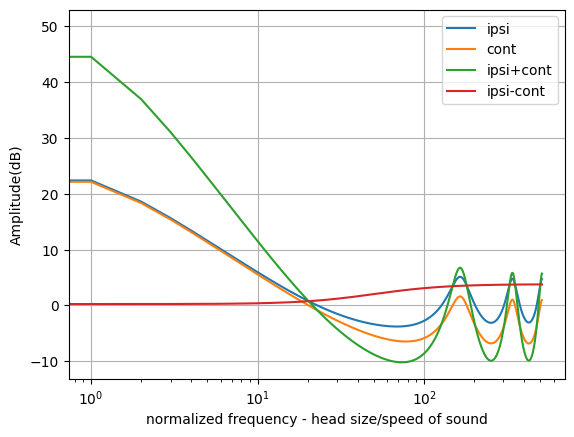

In [3]:
ipsilateral_b, ipsilateral_a, contralateral_b, contralateral_a = dipole_response(0.17, 0.72)

w1, h_ipsi = freqz(ipsilateral_b, ipsilateral_a)
w2, h_cont = freqz(contralateral_b, contralateral_a)

amp_ipsi = 20 * np.log10(np.abs(h_ipsi))
amp_cont = 20 * np.log10(np.abs(h_cont))

plt.plot(amp_ipsi, label = "ipsi")
plt.plot(amp_cont, label = "cont")
plt.plot(amp_ipsi+amp_cont, label = "ipsi+cont")
plt.plot(amp_ipsi-amp_cont, label = "ipsi-cont")
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - head size/speed of sound")
plt.show()